# Tutorial 3: Convolutional Neural Networks

In this tutorial we will:


1.   Revise how tensors work and how images are represented as tensors
2.   Load and visualize a dataset
3.   Build and train a simple MLP classifier
4.   Standardize the data distribution and achieve better accuracy
5.   Understand how convolutional works on images
6.   Build and train a simple CNN classifier






General tips for PyTorch:

The documentation is very well written and is your best friend. Get familiar with it and use it often. https://pytorch.org/docs/stable/index.html

PyTorch has a big userbase, if you ever encounter an error, be sure someone else has encountered it before. Don't be afraid to Google it to find the answer.

## 1. Images as torch tensors

Let's have a look at how images are represented as tensors

In [26]:
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

import numpy as np
import time

In [27]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


If the device is cpu, go to Runtime -> Change runtime type -> T4 GPU -> Save

### What's special about torch tensors?

1.   Torch tensors can be used on GPUs which are much faster than CPUs at large parallel computations
2.   Torch automatically keeps track of the gradient information

In [28]:
# CPU vs GPU

dim=600

x=torch.randn(dim,dim,dim)
y=torch.randn(dim,dim,dim)
start_time = time.time()
z=torch.matmul(x,y)
elapsed_time = time.time() - start_time
print('CPU_time = ', elapsed_time)


x=torch.randn(dim,dim,dim,device=device)
y=torch.randn(dim,dim,dim,device=device)
start_time = time.time()
z=torch.matmul(x,y)
elapsed_time = time.time() - start_time
print('GPU_time = ',elapsed_time)

CPU_time =  0.5557405948638916
GPU_time =  0.0019998550415039062


In [29]:
# Torch tensors automatically keep track of the gradient information
x=torch.rand(64, requires_grad=True)

f1=4*x
f2=6*x

function=(f1+f2).sum()

function.backward()
print(x.grad)

x = x.detach()
print(x.grad)

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10.])
None


Let's see how we can load images with to numpy arrays

(256, 256, 3)


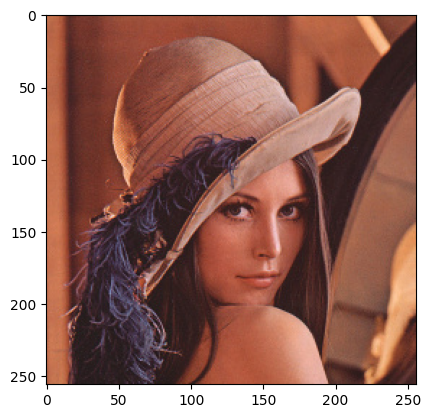

In [30]:
import matplotlib.pyplot as plt
import requests
# import cv2
from PIL import Image
from io import BytesIO

# Display the image from a URL
url = "https://www.jpchacha.com/blog/content/00000002/lena_256.jpg"
response = requests.get(url, allow_redirects=True)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)

plt.imshow(img_array)
print(img_array.shape)

In [31]:
print(img_array[3])

[[193 111  74]
 [193 113  76]
 [190 110  73]
 [190 110  73]
 [189 109  72]
 [188 105  71]
 [188 105  71]
 [186 102  68]
 [186 100  67]
 [175  90  59]
 [176  93  63]
 [162  81  54]
 [142  65  45]
 [127  60  44]
 [106  52  40]
 [ 97  50  40]
 [ 91  48  41]
 [ 99  54  48]
 [102  53  46]
 [108  54  44]
 [112  53  45]
 [123  63  53]
 [121  61  51]
 [121  61  51]
 [117  54  45]
 [117  54  45]
 [124  61  52]
 [118  58  48]
 [115  55  44]
 [114  54  43]
 [112  52  41]
 [116  56  45]
 [119  59  48]
 [118  58  48]
 [115  57  46]
 [119  61  50]
 [123  63  52]
 [123  59  47]
 [125  59  45]
 [134  67  51]
 [139  71  52]
 [144  73  55]
 [145  74  56]
 [143  74  58]
 [143  74  59]
 [143  74  59]
 [148  77  59]
 [156  81  62]
 [149  77  55]
 [154  82  58]
 [154  79  56]
 [153  79  54]
 [160  84  60]
 [156  80  57]
 [160  84  61]
 [159  82  62]
 [160  82  59]
 [158  80  57]
 [157  81  58]
 [155  79  56]
 [156  80  57]
 [158  82  59]
 [156  79  59]
 [154  79  58]
 [157  80  60]
 [158  81  61]
 [157  79 

By default, numpy loads images with the "height, width, channels" dimension format. When processing images with torch, it expects them to have the following shape:

[B, C, H, W]

Where:

*  B -> Dimension of the batch size
*  C -> Number of channels for each image (RGB images have 3, black and white images 1)
*  H -> Height of each image in the batch
*  W -> Width of each image in the batch

Let's reshape the image accordingly.

In [32]:
img_tensor = torch.from_numpy(img_array)
img_tensor = torch.transpose(img_tensor, 0, 2).unsqueeze(0)

print(img_tensor)
print(img_tensor.shape)

tensor([[[[195, 196, 197,  ..., 169, 168, 165],
          [198, 198, 198,  ..., 181, 179, 175],
          [195, 193, 194,  ..., 190, 188, 187],
          ...,
          [144, 142, 142,  ...,  63,  65,  66],
          [150, 148, 148,  ...,  69,  69,  67],
          [149, 150, 144,  ...,  70,  69,  73]],

         [[111, 112, 115,  ...,  88,  87,  85],
          [114, 114, 116,  ..., 100,  98,  96],
          [111, 109, 112,  ..., 107, 107, 108],
          ...,
          [ 78,  78,  78,  ...,  37,  39,  38],
          [ 80,  82,  82,  ...,  41,  39,  37],
          [ 74,  79,  78,  ...,  39,  38,  42]],

         [[ 75,  76,  78,  ...,  61,  60,  58],
          [ 77,  78,  79,  ...,  71,  69,  66],
          [ 74,  72,  75,  ...,  75,  77,  77],
          ...,
          [ 54,  53,  53,  ...,  36,  38,  37],
          [ 55,  56,  58,  ...,  40,  39,  35],
          [ 51,  57,  54,  ...,  37,  36,  40]]]], dtype=torch.uint8)
torch.Size([1, 3, 256, 256])


The value of the pixels are in Unsigned Integer 8 format, having values ranging from 0 to 255. When we process the images however, we will want to have floats in in an easier to operate range for neural networks.

The batch size here is 1 because we only have 1 image in this tensor.

The height and width are 256. In case of storing multiple images in the same tensor, they must all have the same shapes. If they don't we can apply some [padding](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html)

## 2. Load and create a dataset with Torch

Torch has some utilities that allow us to load and create datasets very easily. Let's load the Fashion MNIST dataset

In [33]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [34]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [35]:
batch_size = 64

# Get length of training and test dataset
print(f"The training data has: {len(training_data)} samples")
print(f"The test data has: {len(test_data)} samples")

# Let's investigate what a data entry is like
print(f"Each data sample is a {type(training_data[0])} of length {len(training_data[0])}")
print(f"The first entry is a {type(training_data[0][0])} of shape {training_data[0][0].shape}")
print(f"The second entry is the label: {training_data[0][1]}\n")

The training data has: 60000 samples
The test data has: 10000 samples
Each data sample is a <class 'tuple'> of length 2
The first entry is a <class 'torch.Tensor'> of shape torch.Size([1, 28, 28])
The second entry is the label: 9



Now that we have downloaded the data, let's move it into pytorch dataloaders

In [36]:
# Let's load the dataset into PyTorch dataloaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size
)

for X, y in test_dataloader:
    print(f"Shape of X [B, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [B, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Dataset visualization

Visualize the classes of the dataset

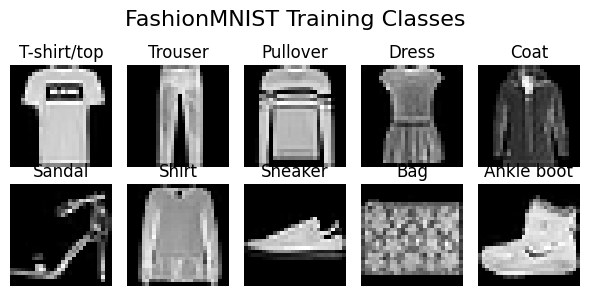

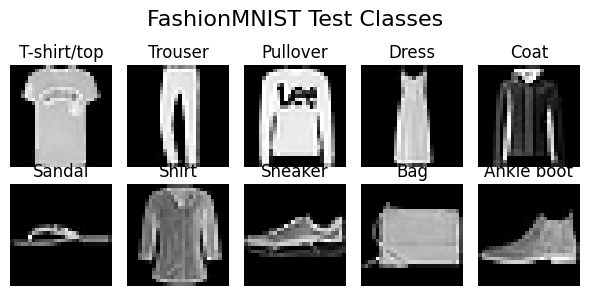

In [37]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

training_labels = training_data.classes
# Set up the plot
fig, axes = plt.subplots(2, 5, figsize=(6, 3))
fig.suptitle("FashionMNIST Training Classes", fontsize=16)

# Plot one image for each class
for i, ax in enumerate(axes.flat):
    for img, label in training_data:
        if label == i:
            break
    
    # Plot the image
    ax.imshow(img.squeeze(), cmap='grey')
    ax.set_title(training_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()
# np.array(test_data)
# np.ndarray(test_data.data)

test_labels = test_data.classes


fig, axes = plt.subplots(2, 5, figsize=(6, 3))
fig.suptitle("FashionMNIST Test Classes", fontsize=16)

# Plot one image for each class
for i, ax in enumerate(axes.flat):
    for img, label in test_data:
        if label == i:
            break
    
    # Plot the image
    ax.imshow(img.squeeze(), cmap='grey')
    ax.set_title(training_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [38]:
x = training_data[0]
print(x[0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

## 3. Build a simple MLP classifier

Before moving to CNNs, let's create a simple MLP classifier. To work with images. In order for the MLP to process an image, you will have to flatten the input image to a single dimension. Have a look on pytorch documentation for nn.Flatten

In [39]:
# Define model
class MLP(nn.Module):
    def __init__(self, img_size = 28*28, hidden_size=512, output_classes=10):
        #Call parent init
        super().__init__()
        self.flatten: nn.Flatten = nn.Flatten()
        # Using nn.ModuleList to store layers
        self.layers = nn.Sequential(
            nn.Linear(img_size, hidden_size),  # 28x28 is the size of FashionMNIST images
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_classes)  # 10 output classes for FashionMNIST
        )
    # Define the forward pass
    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)
    
model = MLP().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(count_parameters(model))

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
669706


In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Let's define a train and test function

In [41]:
def train(dataloader: DataLoader, model: MLP, loss_fn: nn.CrossEntropyLoss, optimizer: torch.optim.SGD):
    # set model to training
    model.train()

    train_length = len(dataloader)

    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch, (X, y) in enumerate(dataloader):
            X = X.cuda()
            y = y.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()                
            # Forward pass
            pred = model(X)        
    # Compute loss
            loss = loss_fn(pred, y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            train_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(pred.data, 1)
            total_predictions += y.size(0)
            correct_predictions += (predicted == y).sum().item()
            
            # Print progress
            if batch % 100 == 0:
                    print(f"Batch [{batch+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    # Compute average loss and accuracy for the epoch
    avg_loss = train_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy}")

    return avg_loss, accuracy

In [42]:
def test(dataloader: DataLoader, model: MLP, loss_fn: nn.CrossEntropyLoss):
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    # Disable gradient computation for efficiency
    with torch.no_grad():
        for X, y in dataloader:
            # Move data to the specified device (CPU or GPU)
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            prediction = model(X)
            
            # Compute loss
            loss = loss_fn(prediction, y)
            
            # Accumulate loss
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(prediction.data, 1)
            total_predictions += y.size(0)
            correct_predictions += (predicted == y).sum().item()

    # Compute average loss and accuracy for the dataset
    avg_loss = test_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy}")

    return avg_loss, accuracy


In [43]:
# epochs = 5
# avg_loss = []
# accuracy = []
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     loss, acc = train(train_dataloader, model, loss_fn, optimizer)
#     avg_loss.append(loss)
#     accuracy.append(acc)
#     test(test_dataloader, model, loss_fn)
# print("Done!")

In [44]:
# import seaborn as sns

# sns.lineplot(avg_loss)
# sns.lineplot(accuracy)


## 4. Can we get better performance?

Hopefully got got accuracy better than random (10%), if not, something is wrong with your code. But can we get better performance than this?
Let's try to standardize the data. We can do this by subtracting the mean and dividing by the standard deviation

In [45]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

def compute_mean_std(dataloader):
    total_sum = 0
    total_squared_sum = 0
    total_pixels = 0
    
    for data, _ in dataloader:
        total_sum += torch.mean(data)
        total_squared_sum += torch.mean(data**2)
        total_pixels += data.numel()
    
    mean = total_sum / len(dataloader)
    std = (total_squared_sum / len(dataloader) - mean ** 2) ** 0.5
    
    return mean.item(), std.item()


# Compute mean and std
mean, std = compute_mean_std(train_dataloader)

print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

Dataset mean: 0.2860540747642517
Dataset std: 0.35303083062171936


In [46]:
# Now normalize the data. Have a look at transforms.Compose to concatenate multiple sequential data transformations
# transforms.Normalize is what you want to use here

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################


data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms,
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)


#WHY THE FUCK ARE WE CALCULATING MEAN LIKE THIS???
# I ALREADY CALCULATED IT... smh
# mean = 0.
# std = 0.
# for images, _ in train_dataloader:
#     batch_samples = images.size(0)
#     images = images.view(batch_size, -1)
#     mean += images.mean(1).sum()
#     std += images.std(1).sum()

# mean /= len(train_dataloader.dataset)
# std /= len(train_dataloader.dataset)


print(mean, std)

0.2860540747642517 0.35303083062171936


In [149]:
# Let's train again
model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

accuracy = 0
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Batch [1/938], Loss: 2.2734
Batch [101/938], Loss: 2.2064
Batch [201/938], Loss: 2.1249
Batch [301/938], Loss: 2.0317
Batch [401/938], Loss: 1.9588
Batch [501/938], Loss: 1.8862
Batch [601/938], Loss: 1.7838
Batch [701/938], Loss: 1.6811
Batch [801/938], Loss: 1.5525
Batch [901/938], Loss: 1.4935
Epoch 2
-------------------------------
Batch [1/938], Loss: 1.4465
Batch [101/938], Loss: 1.3060
Batch [201/938], Loss: 1.3555
Batch [301/938], Loss: 1.1347
Batch [401/938], Loss: 1.3085
Batch [501/938], Loss: 1.1019
Batch [601/938], Loss: 0.9695
Batch [701/938], Loss: 1.0514
Batch [801/938], Loss: 1.0087
Batch [901/938], Loss: 0.8981
Epoch 3
-------------------------------
Batch [1/938], Loss: 1.0585
Batch [101/938], Loss: 0.9529
Batch [201/938], Loss: 0.9949
Batch [301/938], Loss: 0.9752
Batch [401/938], Loss: 0.6946
Batch [501/938], Loss: 0.7591
Batch [601/938], Loss: 0.8978
Batch [701/938], Loss: 0.7134
Batch [801/938], Loss: 0.8834
Batch [901/938],

### Deep learning models are only as good as the data they are trained on
With simple data normalization we managed to increase performance significantly

## 5. How does convolution work on images?

In the ancient days of classical computer vision, convolution was used to extract edges and features from images. This was done with predefined filters, such as Sobel or Laplacian operators, to detect edges, corners, and other basic visual features. The resulting images were then processed further through techniques like thresholding, feature matching, and clustering. These handcrafted features were critical for tasks like object detection and recognition, but they lacked the adaptability and performance of modern deep learning approaches.

Let's see how an edge detector like the sobel filter worked in practice. If you want to know more, have a look [here](http://www.theobjects.com/dragonfly/dfhelp/2021-1/Content/Viewing%20and%20Processing%20Images/Image%20Filtering/Edge%20Detection%20Filters.htm).

torch.Size([1, 3, 512, 512])


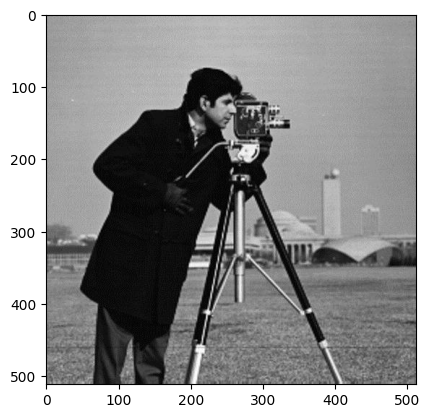

In [137]:
# Display the image from a URL
import requests
from PIL import Image
from io import BytesIO

url = "https://i.sstatic.net/MCZ7o.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

img_array = np.array(img)
plt.imshow(img_array)

# Permute is similar to transpose but allows us to reorder multiple dimensions
# Unsqueeze is creating a new dimension in the position we ask it to (in this case in the batch_size position)
img_tensor = torch.from_numpy(img_array).permute(2,0,1).unsqueeze(0)
print(img_tensor.shape)

In [138]:
# The image is black and white. We only need a single channel, and we need to transform its pixels in the range [0,1] float

img_tensor = torch.mean(img_tensor.float() / 255.0, dim=1, keepdim=True)
print(img_tensor)
print(img_tensor.shape)

tensor([[[[0.5725, 0.6000, 0.6314,  ..., 0.6000, 0.6000, 0.6039],
          [0.6118, 0.6157, 0.6235,  ..., 0.6000, 0.6000, 0.6039],
          [0.6275, 0.6078, 0.5961,  ..., 0.6000, 0.6000, 0.6039],
          ...,
          [0.4706, 0.4784, 0.4824,  ..., 0.4588, 0.4510, 0.4078],
          [0.4824, 0.4745, 0.4745,  ..., 0.4588, 0.4549, 0.4157],
          [0.4745, 0.4667, 0.4784,  ..., 0.4549, 0.4549, 0.4235]]]])
torch.Size([1, 1, 512, 512])


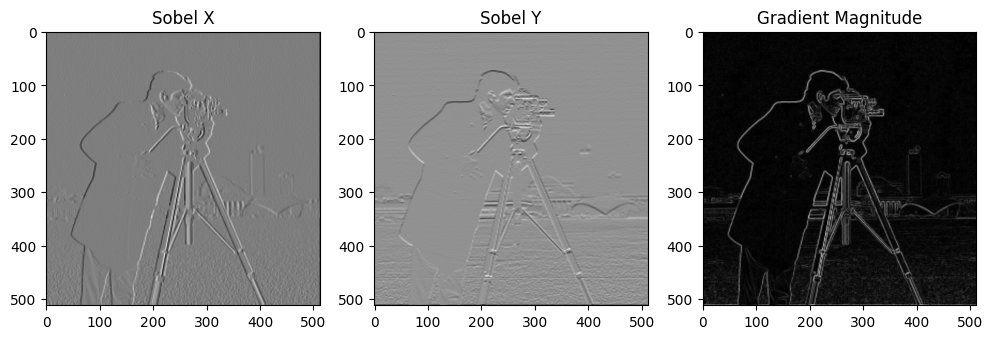

In [139]:
# Define Sobel kernels
sobel_x = torch.tensor([[[[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]]]], dtype=torch.float32)

sobel_y = torch.tensor([[[[-1, -2, -1],
                          [0,  0,  0],
                          [1,  2,  1]]]], dtype=torch.float32)

# Apply Sobel filter in x direction
grad_x = F.conv2d(img_tensor, sobel_x, padding=1)

# Apply Sobel filter in y direction
grad_y = F.conv2d(img_tensor, sobel_y, padding=1)

# Compute magnitude
grad_magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)

grad_x_np = grad_x.squeeze().detach().numpy()
grad_y_np = grad_y.squeeze().detach().numpy()
grad_magnitude_np = grad_magnitude.squeeze().detach().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Sobel X")
plt.imshow(grad_x_np, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Sobel Y")
plt.imshow(grad_y_np, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Gradient Magnitude")
plt.imshow(grad_magnitude_np, cmap='gray')

plt.show()

## 6. Convolutional Neural Networks

Instead of using pre-defined filters, convolutional neural networks (CNNs) learn their own filters directly from data during training. These learned filters automatically adapt to capture relevant features like edges, textures, and complex patterns, enabling more accurate and scalable feature extraction compared to classical methods.

CNNs are the predominant neural networks used in computer vision*

Their main building blocks are convolutions, used for processing information and deriving more complex features, and pooling layers for aggregating and downsampling information.

We will now modify the MLP network we used in tutorial 3, and make a very simple CNN.

*Vision Transformers (ViT) now outperform CNNs on tasks with large data availability (ImageNet for example). We will talk about transformers in a future lecture.

## Build a simple CNN
Let's now build a simple Convolutional Neural Network (CNN) for the same task. The main building blocks of CNNs are convolutions and pooling layers. Have a look at the PyTorch documentation to see how they are defined and what parameters they take as input.

[Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d)

[Avg Pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)


### Build a CNN with the following layers:
* Convolution(in_channel, out_channel, kernel_size, stride, padding)
* Relu
* Average pooling layer
* Convolution(in_channel, out_channel, kernel_size, stride, padding)
* Relu
* Flatten
* Linear(flattened_dimension, 10)

In [50]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, output_classes=10):
        super().__init__()
        self.cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional layer
            nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.AdaptiveAvgPool2d((14,14)),  # Adjust output size to 7x7
            
            # Flatten the output for the fully connected layer
            nn.Flatten(),
            
            # Fully connected layer
            nn.Linear(hidden_channels*2 * 14 * 14, output_classes)
        )

    def forward(self, x):
        return self.cnn(x)
model = SimpleCNN().to(device)

summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
           Flatten-6                [-1, 12544]               0
            Linear-7                   [-1, 10]         125,450
Total params: 144,266
Trainable params: 144,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.72
Params size (MB): 0.55
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


In [51]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Batch [1/938], Loss: 2.3245
Batch [101/938], Loss: 0.5398
Batch [201/938], Loss: 0.5710
Batch [301/938], Loss: 0.4799
Batch [401/938], Loss: 0.4064
Batch [501/938], Loss: 0.4550
Batch [601/938], Loss: 0.2540
Batch [701/938], Loss: 0.4079
Batch [801/938], Loss: 0.3254
Batch [901/938], Loss: 0.2962
Accuracy: 0.84695
Accuracy: 0.8585
Epoch 2
-------------------------------
Batch [1/938], Loss: 0.3461
Batch [101/938], Loss: 0.2869
Batch [201/938], Loss: 0.2270
Batch [301/938], Loss: 0.2383
Batch [401/938], Loss: 0.3003
Batch [501/938], Loss: 0.4157
Batch [601/938], Loss: 0.1481
Batch [701/938], Loss: 0.1386
Batch [801/938], Loss: 0.2090
Batch [901/938], Loss: 0.4311
Accuracy: 0.8984166666666666
Accuracy: 0.8953
Epoch 3
-------------------------------
Batch [1/938], Loss: 0.3364
Batch [101/938], Loss: 0.2934
Batch [201/938], Loss: 0.3277
Batch [301/938], Loss: 0.3002
Batch [401/938], Loss: 0.4342
Batch [501/938], Loss: 0.2020
Batch [601/938], Loss: 0.

# Build an improved CNN

Feel free to experiment with the following blocks:

###Convolutions
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

###Pooling blocks
* [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#avgpool2d)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d)

###Activation functions
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu)
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#leakyrelu)
* [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#gelu)

###Dropout
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout)
* [Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#dropout2d)

###Normalization layers
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#batchnorm2d)
* [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#layernorm)

# Challenge
 Improve performance as much as you can. Can you get close to ~90% accuracy? Only change the CNN, do **not** change optimizers, data transformations or number of epochs. Feel free to change as many layers as you want, make the network wider, deeper whatever you like. Try to keep your network relatively small - don't make it larger than the original MLP (670K params)


Again, PyTorch documentation is your best friend
https://pytorch.org/docs/stable/index.html


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, output_classes=10):
        super().__init__()
        self.cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional layer
            nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.AdaptiveAvgPool2d((14,14)),  # Adjust output size to 7x7
            
            # Flatten the output for the fully connected layer
            nn.Flatten(),
            
            # Fully connected layer
            nn.Linear(hidden_channels*2 * 14 * 14, output_classes)
        )

    def forward(self, x):
        return self.cnn(x)

model = CNN().to(device)

summary(model, (1,28,28))

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# More advanced CNNs

There exists many different types of CNN models, one of the most common backbones used is the ResNet. Have a look at how more advanced neural networks are built. You can find more here:

https://github.com/kuangliu/pytorch-cifar

In [ ]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())



model = ResNet18().to(device)

summary(model, (3,32,32))

# Optional

1.   If you want to learn more about how CNNs work, try visualizing how their feature extraction pipeline works. Refer to: https://arxiv.org/abs/1311.2901
2.   Beyond image classification, there are many other tasks that CNNs are used for, such as image segmentation, object detection, super resolution and more. Have a look at the U-Net for image segmentation [[1]](https://github.com/milesial/Pytorch-UNet) [[2]](https://arxiv.org/abs/1505.04597)